---

#University of Stirling - Spring 2023
# Cameron Morrison 2831609

## CSCU9M6 - Natural Language Processing and Computer Vision (2022/3)

---

# Assignment Summary

In this activity, you are required to apply the knowledge acquired in this module through the design and development of a complete project for image classification in an application to be defined by yourself. For this, you will need to perform the following **mandatory** steps:

1. [Problem definition](#scrollTo=hglJVRRslqMn)
2. [GitHub repository](#scrollTo=ecxDhkV9qmUf)
3. [Dataset](#scrollTo=qEgFzxmWrGA9)
4. [Dataloader](#scrollTo=EDd6lLwlx4un)
5. [Proposed solution](#scrollTo=ScTrpUW8zOp4)
6. [Experimental tests and evaluations](#scrollTo=3RBW58of0ZDo)
7. [Quiz and Report](#scrollTo=ws14iV4Dp_vf)

**Deadlines** and other details can be seen on Canvas [\[link\]](https://canvas.stir.ac.uk/courses/12587/assignments/102373).

---

# 1. **Problem definition** 


In this assignment, you are required to apply the knowledge acquired in the module to solve a classification problem from images collected in the context of two different cities (A and B).
 - If the work is being carried out in pairs, **cities A and B must be the hometowns of each student**. In the case of individual work, city A must be your hometown and city B must be Stirling (or Edinburgh, if needed).
 - The standard recommendation is that the project focuses on classifying cars or trees image scenes, which are easier to identify and annotate. Other objects or phenomena can be adopted, but are subject to prior approval by the module instructor (Jefersson A. dos Santos). **You are not allowed to assemble datasets containing people. Other sensitive patterns, such as license plates, must be properly hidden.**
 - Don't panic! We are aware that acquiring images _in situ_ is an impediment for most students. The dataset can be assembled with images collected remotely or from public repositories. Just be careful with rights and permissions for using images found on the internet. Anyway, these factors must be taken into account for the problem definition.
 - While we encourage you to do interesting and engaging work, it shouldn't be too complex or time-consuming. Try to appropriately scale the time required for this step. Ask the instructors for advice, if necessary. **GA students:** you are encouraged to link the project with your work activities, but keep in mind you still need to construct two datasets (A and B). 

[top](#scrollTo=4i5afvUbhmGo)
 

---
# 2. **GitHub repository**

Give your project a name, create a private [GitHub repository](https://github.com/) with the name [Module Code] + [Project Name] and give access to the module instructors. Create a cover page with a description of your project. This empty notebook must be uploaded in the repository as well as the created dataset. The deadline to perform this task will be 10 days after the publication of this notebook. 
This notebook should be updated and committed to the repository according to the deadlines.
The repository's update history will be used as a criterion for monitoring and evaluating the work.
**Check the videos provided in the extra section on Canvas for more details on how to create your GitHub repository** [\[link\]](https://canvas.stir.ac.uk/courses/12587/pages/extra-session-cnn-hyperparameters-and-github).

[top](#scrollTo=4i5afvUbhmGo)

---
# 3. **Dataset creation**

You must collect a minimum of **200 positive samples** from the study objects for each city (A and B). 
Note that, depending on the task being solved, it will also be necessary to collect more samples - negative ones, for instance.

Your dataset can be assembled from one or more of the following ways:

  - *M1* - Pictures taken by yourself on site (street view from cities A and B), with attention to anonymization issues (if it is the case). It is not allowed to assemble datasets containing people. Other sensitive patterns, such as license plates, must be properly hidden.

  - *M2* - Aerial satellite/drone images obtained from GIS and remote sensing platforms or public repositories. Be careful with unusual file formats that may be challenging to manipulate using basic image processing libraries. We recommend keeping or converting the images to jpg or png.

  - *M3* - Pictures taken from other public available datasets. Remember you are not allowed to use datasets containing people or other sensitive patterns/objects.

  - *M4* - Images crawled from the internet as a whole (social networks, webpages, etc), with special attention to use and copyrights.

  - *M5* - Textual and metadata you may need in your project, with special attention to use and copyrights (as always!).

**Important:** If you collect the images on your own or from aerial imagery repositories, it will be necessary to keep the geographic coordinates. If you collect from specific websites, please retain the source links. This information should be placed in a .csv file and made available along with the final dataset.

[top](#scrollTo=4i5afvUbhmGo)

---

# 4. **Dataloader**

Here you are required to implement all the code related to pre-processing, cleaning, de-noising and preparing the input images and metadata according to the necessary data structures as input to your pattern recognition module. We recommend using [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) or [Tensorflow (with Keras)](https://keras.io/getting_started/intro_to_keras_for_engineers/) as a base, but you are free to use any library or platform as long as it is well justified in the [final report](#scrollTo=ws14iV4Dp_vf).

[top](scrollTo=4i5afvUbhmGo)

https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
#### Cameron Morrison 2831609

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

torch.cuda.empty_cache()

#Stops notebook from crashing and failing to plot
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#Uses cuda cores on graphics card if your device has one, massively improves performance by utilizing parallel processing 
def apply_graphics_card():
    if torch.cuda.is_available():
        dev = "cuda:0"
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        dev = "cpu"
    return torch.device(dev)

C:\Users\Cam-M\anaconda3\envs\torchEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### The following method is used to find the mean and standard deviation needed for normilization transforms. I decided to make a method as Stirling and Edinburgh aerial images have different image quality. Edinburgh is clear and bright whilst Stirling is noisy and dark. Having the method read the dataset and calculate the average will be the optimal match. 

In [2]:
#Global param
batch_size = 32

#Used to find the mean and standard deviation needed for normilization 
def find_normalization_params(root):
    initial_transform = transforms.Compose([
        transforms.Resize((308, 256)),
        transforms.ToTensor()
    ])
    #Loop through all images, totaling the mean and std of the images
    dataset = torchvision.datasets.ImageFolder(root = root, transform=initial_transform)
    batch = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)
    image_count = 0
    mean = 0
    standard_deviation = 0
    for images, _ in batch:
        batch_count = images.size(0)
        images = images.view(batch_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        standard_deviation += images.std(2).sum(0)
        image_count += batch_count
        
    #Divid by the number of images, and return to use for normalization
    mean /= image_count
    standard_deviation /= image_count
    print("AVG Mean values -", mean)
    print("AVG Standard deviation -", standard_deviation)
    return mean, standard_deviation

#### This method displays 6 random images from the train dataloader after the transforms are applied. You will notice the images are saturated, noisy, and rotated. This is intentional as it increases the variety in the training data and results in a more robust model for classification. The modifications are added through transformations except from the noise, as the input images were naturally very noisy. When researching denoising techniques I came across this article which argues against noise is benefical for small datasets. 
https://machinelearningmastery.com/train-neural-networks-with-noise-to-reduce-overfitting/

In [3]:
#Displays examples of transformed/normalized images 
def show_transformed_images(root, dataset):
    loader = torch.utils.data.DataLoader(dataset, 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images)
    plt.figure(figsize=(14, 13))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Dataset city', root, ' and labels: ', labels)

### Dataloader 

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AVG Mean values - tensor([0.4388, 0.4646, 0.4711])
AVG Standard deviation - tensor([0.2038, 0.1917, 0.1757])
Dataset city ./Edinburgh  and labels:  tensor([1, 0, 0, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AVG Mean values - tensor([0.3157, 0.3303, 0.3019])
AVG Standard deviation - tensor([0.1512, 0.1520, 0.1440])
Dataset city ./Stirling  and labels:  tensor([0, 1, 1, 1, 0, 0])


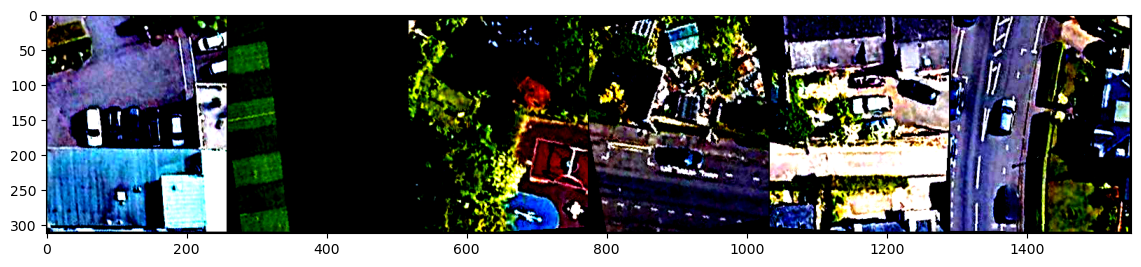

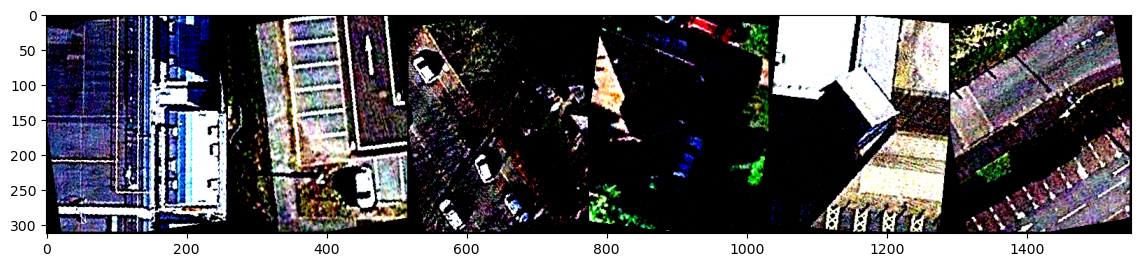

In [4]:
#Loads in data from directories
def dataloader(root):
    mean, std = find_normalization_params(root)
    
    #Random transforms so that existing images are different from entire dataset in test loader
    train_transforms = transforms.Compose([
        transforms.Resize((308, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
    #Keep all images the same for testing
    test_transforms = transforms.Compose([
        transforms.Resize((308, 256)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])
    #Loading datasets with transforms 
    train = torchvision.datasets.ImageFolder(root = root, transform = train_transforms)
    test = torchvision.datasets.ImageFolder(root = root, transform = test_transforms)
    number_of_workers = 0 if sys.platform.startswith('win32') else 4
    
    #Output examples
    show_transformed_images(root, train)
    
    #Shuffled subset 
    training_batch = torch.utils.data.DataLoader(train, batch_size, shuffle = True, num_workers=number_of_workers)
    testing_batch = torch.utils.data.DataLoader(test, batch_size, shuffle = False, num_workers=number_of_workers)
    
    return training_batch, testing_batch

device = apply_graphics_card()
print(device)

#This results in 50% train 50% split as the train data is all distored and transformed whereas the test are the originals.
Edinburgh_train, Edinburgh_test = dataloader("./Edinburgh")
Stirling_train, Stirling_test = dataloader("./Stirling")

---

# 5. **Proposed solution** 

This is where you should implement most of your code for your solution. Write the routines for training and predicting the models and any necessary intermediate steps. Post-processing functions must also be implemented here.

  - Use good programming practices, modularizing and adequately commenting on your code. Code quality will be considered in the final assessment.

  - You can use pre-trained models as backbones or any code available on the web as a basis, but they must be correctly credited and referenced both in this notebook and in the final report. Cite the source link repository and explicitly cite the authors of it.
If you changed existing code, make it clear what the changes were.
Make it clear where your own code starts and where it ends. Note that the originality percentage of the code will be considered in the evaluation, so use external codes wisely and sparingly. **Missconduct alert:** remember that there are many tools that compare existing source code and that it is relatively easy to identify authorship. So, be careful and fair by always properly thanking the authors if you use external code.

[top](#scrollTo=4i5afvUbhmGo)
#### Cameron Morrison 2831609

In [5]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#### Method to train a resnet18 neural network 
https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html

In [6]:
def train(model, train_loader, test_loader, loss_function, optimizer, number_of_epochs, run_name):
    #Assign graphics card for faster computation
    device = apply_graphics_card()
    bestAccuracy = 0.0
    bestLoss = 0.0
    #used for plotting run later
    trainAcc = []
    trainLoss = []
    testAcc = []
    testLoss = []
    for epoch in range(number_of_epochs):
        #sets model to train mode
        model = model.train()
        total = 0
        correct = 0.0
        loss = 0.0
        
        for images, labels in train_loader:
            #Moves items to graphics card for performance
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
       
            #Resets the gradient of model paremters to zero before updating weights and bias
            optimizer.zero_grad()
    
            #predict class of images
            outputs = model(images)
            
            #Calculate gradient of loss and update model parameters
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            loss += loss.item()  * images.size(0)
            correct += (labels==predicted).sum().item()
                  
        epoch_accuracy = 100.0 * correct / total   
        trainAcc.append(epoch_accuracy)
        trainLoss.append(loss.item())
        
        test_epoch_accuracy = 0
        test_epoch_loss = 0
        pred_cfm = []
        true_cfm = []
        
        #Print every 15th epoch to limit output messages otherwise just record results
        if(epoch%15 == 0):
            print("Epoch", (epoch + 1))
            print( " -> Training classified %d/%d images correctly (%.3f%%) with an epoch loss of %.4f" % (correct, total, epoch_accuracy, loss))
            test_epoch_accuracy, test_epoch_loss, true_cfm, pred_cfm = test(model, test_loader, loss_function, True)
        else:
            test_epoch_accuracy, test_epoch_loss, true_cfm, pred_cfm = test(model, test_loader, loss_function, False)
    
        testAcc.append(test_epoch_accuracy)
        testLoss.append(test_epoch_loss)            
        
        #Record the best performance yet
        if(test_epoch_accuracy > bestAccuracy):
            bestAccuracy = test_epoch_accuracy
            bestLoss = test_epoch_loss
            bestTrue_cfm = true_cfm
            bestPred_cfm = pred_cfm
            saveModel(model, run_name)
        
        #If 100% in training and test, break and save model
        if epoch_accuracy == 100.00 and test_epoch_accuracy == 100.00:
            print("OPTIMAL AT Epoch #", (epoch + 1))
            break
            
    #Final results display
    print("Best testing accuracy is %.3f%%" % bestAccuracy, " with a loss of %.4f " % bestLoss)
    #Plot graphs
    plot_run(run_name, trainAcc, trainLoss, testAcc, testLoss)

    return bestTrue_cfm, bestPred_cfm

#### Used to save the best model discovered in the train method as a pytorch script file
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [7]:
def saveModel(model, run_name):
    torch.save(model, run_name + "_best_model.pt")

#### Load the best model (using the run name to identify, as there will be two models)

In [8]:
def loadModel(run_name):
    model = torch.load(run_name + "_best_model.pt")
    model.eval()
    return model

#### Testing model with the test data

In [9]:
def test(model, test_loader, loss_function, displayResult):
    #Switches to testing mode
    model = model.eval()   
    correct = 0
    total = 0
    device = apply_graphics_card()
    loss = 0.0
    
    #Used for confusion matrix
    true_cfm = []
    pred_cfm = []
    
    #No need for gradient calculations so to save memory and speed up we turn it off
    with torch.no_grad():
         for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            true_cfm.extend(labels.cpu().numpy())
            total += labels.size(0)
              
            outputs = model(images)
            
            #Record testing loss
            loss = loss_function(outputs, labels)
            loss += loss.item() * images.size(0)
     
            _, predicted = torch.max(outputs.data, 1)
            pred_cfm.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
         
    accuracy = 100.0 * correct / total

    if(displayResult):
         print( " -> Testing classified %d/%d images correctly (%.3f%%) with an epoch loss of %.4f" % (correct, total, accuracy, loss))
    return accuracy, loss.item(), true_cfm, pred_cfm

#### Setting up pytorch model 
https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [10]:
def create_new_resnet18_model():
    
    #Creates a ResNet-18 model with no pretrained weights
    rsn18_model = models.resnet18(pretrained=False)
    #Hard coded number of classes 0 for no car and 1 for car
    number_of_classes = 2
    #number of inputs for the linear layer which maps the output of the network to the classifications
    number_of_features = rsn18_model.fc.in_features
    rsn18_model.fc = nn.Linear(number_of_features, number_of_classes)
    #Move to graphics card
    rsn18_model = rsn18_model.to(device)
    #Loss function used for classification problems
    loss_function = nn.CrossEntropyLoss()
    #Stochastic gradient decent (SGD) with a learning rate of 0.01, momentum of 0,9 and weight decay of 0.003
    optimizer = optim.SGD(rsn18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
    
    return rsn18_model, loss_function, optimizer

---

# 6. **Experimental tests and evaluations** 


Here you must implement your code for training, testing and evaluating your solution. For this, the following code blocks (*E1*, *E2*, and *E3*) are mandatory:

  - *E1* - Training the models. Implement code to call the dataloaders implemented for training your models.  Make routines to test different parameters of your models. Plot graphs that illustrate how parameters impact model training. Compare. Train and select a model for each city (A and B) and justify. You should use half (50%) of the samples from each dataset for training and leave the other half for testing (50%). 

[top](#scrollTo=4i5afvUbhmGo)

  - *E2* - Testing the models in the dataset. You must implement code routines to test the predictive ability of your models using half of each dataset intended for testing. **The model trained in city A must be tested in city A. The model trained in city B must be tested in city B.** Use the evaluation metrics (accuracy, F1-score, AUC, etc) that are most appropriate for your problem. Plot graphs that illustrate the results obtained for each city (A and B). Plot visual examples of correctly (true positive) and incorrectly (false positive) classified samples. 

[top](#scrollTo=4i5afvUbhmGo)

#### Cameron Morrison 2831609

#### Plots two graphs of accuracy/loss for train and test horizontally next to eachother 

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_run(run_name, train_accuracy, train_loss, test_accuracy, test_loss):
    
    # create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # plot training accuracy and loss
    axs[0].plot(train_accuracy, label='Training accuracy')
    axs[0].plot(test_accuracy, label='Testing accuracy')
    axs[0].set_title(run_name + " accuracy")
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # plot test accuracy and loss
    axs[1].plot(train_loss, label='Training loss')
    axs[1].plot(test_loss, label='Testing loss')
    axs[1].set_title(run_name + " loss results")
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()

#### PLots confusion matrix using recorded run values

In [12]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

def confusion_matrix_and_metrics(true, pred):
    cf_matrix = confusion_matrix(true, pred)
    class_names = ("Car", "Not car")
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(3, 3))
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="Blues",fmt="d")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()
    
    pres = precision_score(true, pred, average='binary')
    f1 = f1_score(true, pred, average='binary')
    acc = accuracy_score(true, pred)
    recall = recall_score(true, pred, average='binary')
    print("Precision: %.3f, F1: %.3f, Accuracy: %.3f, recall: %.3f." % (pres, f1, acc, recall))

#### Edinburgh trained and tested on Edinburgh dataset 

C:\Users\Cam-M\anaconda3\envs\torchEnv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cam-M\anaconda3\envs\torchEnv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1
 -> Training classified 320/520 images correctly (61.538%) with an epoch loss of 5.0930
 -> Testing classified 362/520 images correctly (69.615%) with an epoch loss of 3.4905
Epoch 16
 -> Training classified 472/520 images correctly (90.769%) with an epoch loss of 0.3869
 -> Testing classified 483/520 images correctly (92.885%) with an epoch loss of 0.3716
Epoch 31
 -> Training classified 497/520 images correctly (95.577%) with an epoch loss of 1.0938
 -> Testing classified 508/520 images correctly (97.692%) with an epoch loss of 0.0002
Epoch 46
 -> Training classified 503/520 images correctly (96.731%) with an epoch loss of 2.4234
 -> Testing classified 469/520 images correctly (90.192%) with an epoch loss of 0.0000
Epoch 61
 -> Training classified 483/520 images correctly (92.885%) with an epoch loss of 0.0908
 -> Testing classified 506/520 images correctly (97.308%) with an epoch loss of 0.0278
Epoch 76
 -> Training classified 513/520 images correctly (98.654%) with an epoch

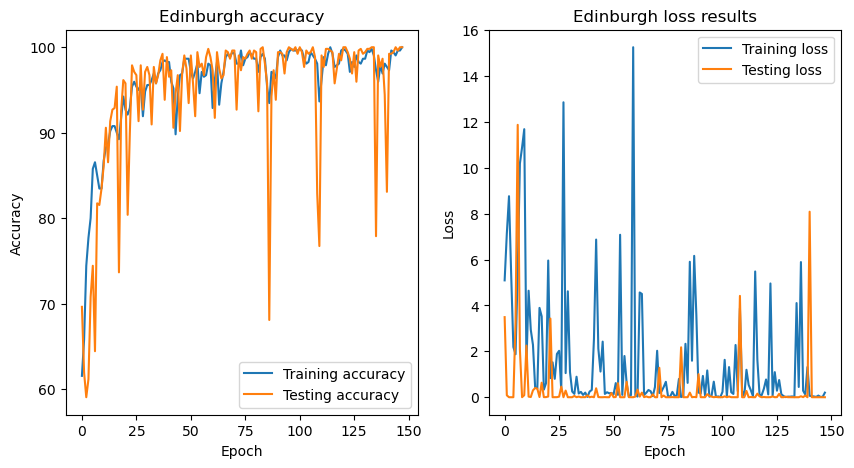

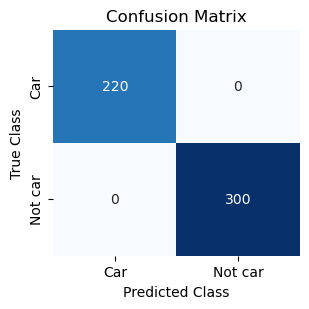

Precision: 1.000, F1: 1.000, Accuracy: 1.000, recall: 1.000.


In [13]:
#Create blank nn
model, loss_function, optimizer = create_new_resnet18_model()
#Train, evaluate and save 
true_cfm, pred_cfm = train(model, Edinburgh_train, Edinburgh_test, loss_function, optimizer, 150, "Edinburgh")
confusion_matrix_and_metrics(true_cfm, pred_cfm)

#### Stirling trained and tested on Stirling dataset

C:\Users\Cam-M\anaconda3\envs\torchEnv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cam-M\anaconda3\envs\torchEnv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1
 -> Training classified 315/490 images correctly (64.286%) with an epoch loss of 8.1325
 -> Testing classified 354/490 images correctly (72.245%) with an epoch loss of 3.5417
Epoch 16
 -> Training classified 457/490 images correctly (93.265%) with an epoch loss of 4.1929
 -> Testing classified 442/490 images correctly (90.204%) with an epoch loss of 5.6981
Epoch 31
 -> Training classified 471/490 images correctly (96.122%) with an epoch loss of 1.8837
 -> Testing classified 470/490 images correctly (95.918%) with an epoch loss of 0.1157
Epoch 46
 -> Training classified 476/490 images correctly (97.143%) with an epoch loss of 0.4369
 -> Testing classified 481/490 images correctly (98.163%) with an epoch loss of 0.1125
Epoch 61
 -> Training classified 487/490 images correctly (99.388%) with an epoch loss of 0.0524
 -> Testing classified 488/490 images correctly (99.592%) with an epoch loss of 0.1781
Epoch 76
 -> Training classified 480/490 images correctly (97.959%) with an epoch

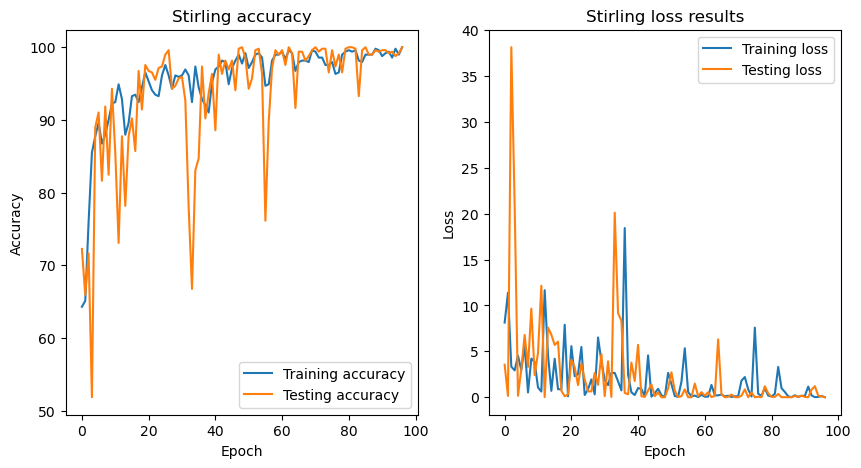

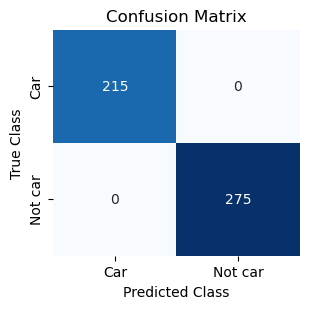

Precision: 1.000, F1: 1.000, Accuracy: 1.000, recall: 1.000.


In [14]:
#Create new model for stirling
model, loss_function, optimizer = create_new_resnet18_model()
#Train, evaluate and save 
true_cfm, pred_cfm = train(model, Stirling_train, Stirling_test, loss_function, optimizer, 150, "Stirling")
confusion_matrix_and_metrics(true_cfm, pred_cfm)

  - *E3* - Testing the models crossing datasets. Here you must do exactly the same as in *E2*, but now training in one city and testing in the other. **The model trained in city A must be tested in city B. The model trained in city B must be tested in city A.** Use the same metrics and plot the same types of graphs so that results are comparable.

[top](scrollTo=4i5afvUbhmGo)

#### Crossing datasets
I suspect that the bright and high quality images of Edinburgh will make the model poorly classifying the noisy/dark images of the Stirling area obtained from Google earth pro due to the differences in the source imagery. 

The Stirling testing data evaluated using the Edinburgh model resulted in:
 -> Testing classified 423/490 images correctly (86.327%) with an epoch loss of 3.8156


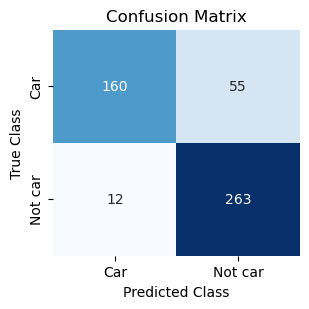

Precision: 0.827, F1: 0.887, Accuracy: 0.863, recall: 0.956.
The Edinburgh testing data evaluated using the Stirling model resulted in:
 -> Testing classified 437/520 images correctly (84.038%) with an epoch loss of 4.4117


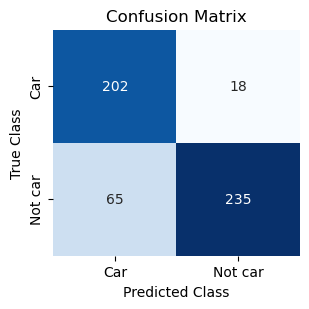

Precision: 0.929, F1: 0.850, Accuracy: 0.840, recall: 0.783.


In [15]:
Stirling_model = loadModel("Stirling")
Edinburgh_model = loadModel("Edinburgh")

#Stirling testing data evaluated using the Edinburgh model
print("The Stirling testing data evaluated using the Edinburgh model resulted in:")
Stirling_tested_in_Edinburgh, _, true_cfm, pred_cfm = test(Edinburgh_model, Stirling_test, loss_function, True)
confusion_matrix_and_metrics(true_cfm, pred_cfm)

#Edinburgh testing data evaluated using the Stirling model
print("The Edinburgh testing data evaluated using the Stirling model resulted in:")
Edinburgh_tested_in_Stirling, _, true_cfm, pred_cfm = test(Stirling_model, Edinburgh_test, loss_function, True)
confusion_matrix_and_metrics(true_cfm, pred_cfm)

---

# 7. **Quiz and Report**

Answer the assessment quiz that will be made available on Canvas one week before the final deadline. Make a 2-page report using the [IEEE template](https://www.overleaf.com/read/rdqwshtvyjdn) with a maximum of 1000 words. Latex is recommended, but you can deliver the report in MS Word if you prefer. Your report should contain five sections: introduction, description of the proposed solution with justifications, results (here you can include the same graphs and pictures generated in this jupyter notebook), discussion of the results, and conclusion. Properly cite references to articles, tutorials, and sources used. A pdf version of your report should be made available in the project's github repository under the name "[project name] + _final_report.pdf".


[top](#scrollTo=4i5afvUbhmGo)